In [17]:
!nvidia-smi

Wed Jul 22 05:00:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |   8739MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
##Mounting google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
from keras import datasets, Model
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from keras.applications import InceptionResNetV2, NASNetLarge
from keras import optimizers


In [20]:
import cv2
import os
#將訓練集轉換成numpy array，並resize後，改成float32 dtype
#利用folder name幫每個圖檔上標籤Label
main_path = "/content/drive/My Drive/ml100-03-final/image_data/train/"
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}
df = pd.DataFrame()
images= []
labels = []
for k in flower_mapping.keys():
    path = main_path + k
    label = flower_mapping[k]
    
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.resize(img, (331, 331), interpolation=cv2.INTER_CUBIC) #不resize的話，會衍生很多問題，插值法選擇INTER_CUBIC
        if img is not None:
            images.append(img.astype(np.float32))   #key point，因為每張圖大小不同，所以在轉換float32時，會出現error
            labels.append(label)                    #所以在單張圖時就要轉換成float32

print("訓練組共有", len(images), "張圖")
print("訓練組共有", len(labels), "個標籤")
#每張圖尺寸不同
print(np.array(images)[44].shape)
print(np.array(images)[104].shape)
print(np.array(images)[44].dtype)

訓練組共有 2823 張圖
訓練組共有 2823 個標籤
(331, 331, 3)
(331, 331, 3)
float32


In [21]:
# CV2 resize, refer to https://shengyu7697.github.io/blog/2019/11/10/Python-OpenCV-resize/
# 如果是要縮小圖片的話，通常 INTER_AREA 使用效果較佳。
# 如果是要放大圖片的話，通常 INTER_CUBIC 使用效果較佳，次等則是 INTER_LINEAR。
# 如果要追求速度的話，通常使用 INTER_NEAREST。

In [22]:
main_path = "/content/drive/My Drive/ml100-03-final/image_data/test/"
images_test= []
filenames = []
for filename in os.listdir(main_path):
    img = cv2.imread(os.path.join(main_path, filename))
    img = cv2.resize(img, (331, 331), interpolation=cv2.INTER_CUBIC)
    filenames.append(filename)
    if img is not None:
        images_test.append(img.astype(np.float32))  
print("預測組共有：",len(images_test))
print("檔案名共有：",len(filenames))                           

預測組共有： 2000
檔案名共有： 2000


In [23]:
#從訓練集中拆分出訓練組及驗證組
from sklearn.model_selection import train_test_split
dataset = np.array(images)   #List轉換成numpy array
labels = np.array(labels)   #把labels接到dataset屁股在進行shuffle

#同時shuffle出訓練組及驗證組with different dimensions
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))  #permutation可shuffle一個給予的序列或是range，這裡給予len(a)，就是range也是a的index，所以a[p]就是以shuufle後的index重新排列的numpy array
    return a[p], b[p]
dataset, labels = unison_shuffled_copies(dataset, labels)

#需要重新區分出train, test set作為ImageDataGenerator用
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=True, random_state=42, stratify=labels) #使用ImageDataGenerator前，需要stratify=labels使標籤打亂，不然會出現錯誤
X_train = X_train/255
X_test = X_test/255

#Label 以one-hot encoder編碼
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 5)
y_test = np_utils.to_categorical(y_test, 5)

In [24]:
#using InceptionV2 have to add input_shape=(256,256,3) in conv_base, ResNet50, Xception, NASNetLarge did not.
# conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256,256,3))
conv_base = InceptionResNetV2(weights='imagenet', include_top=False)

In [25]:
#conv_base.summary()
len(conv_base.layers)

780

In [26]:
conv_base = InceptionResNetV2(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(conv_base.output)
output = Dense(5, activation='softmax')(x)
model = Model(conv_base.input, output)
#設定凍結與要進行訓練的網路層, InceptionResNetV2設定凍結770層(total 780 layers)，是目前為止training set前三epoch最快進入train_acc=0.983 val_acc=0.935的model
freeze_layers = 760
for layer in conv_base.layers[:freeze_layers]:
    layer.trainable = False
for layer in conv_base.layers[freeze_layers:]:
    layer.trainable = True
model.compile(optimizer=optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy']) #metrics, binary_crossentropy使用的是binary_accuracy，categorical_crossentropy使用的是categorical_accuracy
callbacks_list = [ModelCheckpoint(filepath='test.hdf5', save_best_only=True), ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]



In [27]:
#增加圖片, transfer learning所借用的model，執行後如果前五個eopch都無法fit達到到val_acc=0.9以上則放棄
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=30,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                             horizontal_flip=True, vertical_flip=False, fill_mode="nearest", validation_split=0.3)
train_generator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True, subset="training")   
valid_generator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True, subset="validation") #batch_size=64-128, 是Tesla P100-PCIE速度較能接受的範圍

history = model.fit_generator(train_generator, steps_per_epoch=100, validation_data=valid_generator 
                              , epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
100/100 [==============================] - 140s 1s/step - loss: 0.1876 - accuracy: 0.9257 - val_loss: 0.1476 - val_accuracy: 0.9185
Epoch 2/50
100/100 [==============================] - 122s 1s/step - loss: 0.0744 - accuracy: 0.9736 - val_loss: 0.2233 - val_accuracy: 0.9276
Epoch 3/50
100/100 [==============================] - 126s 1s/step - loss: 0.0461 - accuracy: 0.9839 - val_loss: 0.2852 - val_accuracy: 0.9371
Epoch 4/50
100/100 [==============================] - 126s 1s/step - loss: 0.0289 - accuracy: 0.9903 - val_loss: 0.2674 - val_accuracy: 0.9341
Epoch 5/50
100/100 [==============================] - 127s 1s/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.3408 - val_accuracy: 0.9309
Epoch 6/50
100/100 [==============================] - 129s 1s/step - loss: 0.0185 - accuracy: 0.9938 - val_loss: 0.2338 - val_accuracy: 0.9347
Epoch 7/50
100/100 [==============================] - 134s 1s/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.2838 - val_accuracy: 0.9374

In [28]:
def plot_loss_acc(X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("test_loss=", test_loss)
    print("test_acc=", test_acc)
    val_loss = history.history["val_loss"]
    loss = history.history["loss"]
    plt.plot(val_loss, label="val_loss")
    plt.plot(loss, label="loss")
    plt.hlines(y=test_loss, xmin=0, xmax=len(val_loss), colors='r', linestyles='--')
    plt.legend()
    plt.show()
    val_accuracy = history.history["val_accuracy"]
    accuracy = history.history["accuracy"]
    plt.plot(val_accuracy, label="val_accuracy")
    plt.plot(accuracy, label="accuracy")
    plt.hlines(y=test_acc, xmin=0, xmax=len(val_accuracy), colors='r', linestyles='--')
    plt.legend()
    plt.show()

565/565 [==============================] - 6s 10ms/step
test_loss= 0.32480471028690844
test_acc= 0.9306194186210632


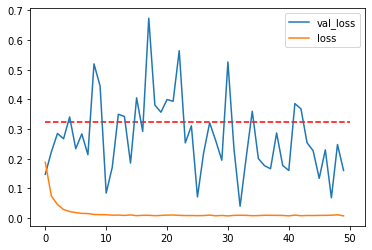

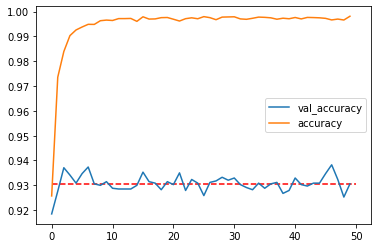

In [29]:
plot_loss_acc(X_test, y_test)

In [30]:
# 開始預測
from keras.models import load_model
images_test = np.array(images_test)
images_test = images_test/255
path_model = "/content/test.hdf5"
model = load_model(path_model)
#pred_test = model.predict_classes(images_test) #只適用於model=Sequential()
pred_test = model.predict(images_test)
pred_test = np.argmax(pred_test,axis=1)

In [31]:
df_sub = pd.DataFrame(data={"id":filenames, "flower_class":pred_test})
df_sub["id"] = [i[0] for i in df_sub["id"].str.split(".")]

In [32]:
df_sub.to_csv("df_sub_4.csv", index=False)
from google.colab import files
files.download('df_sub_4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>